# HydroSOS Streamflow Status Product Methodology
#### Jose Valles (jose.valles.leon@gmail.com)

## One month status product

### Importing the data and finding missing dates

In [637]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

Import de daily discharge from a hydrological station located in Uruguay 

In [638]:
station_name = 'maldonado'
DISCHARGE_DAILY = pd.read_csv(f'../data/{station_name}_caudales.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")

Identify the missing dates and change dataframe columns name

In [639]:
# Identify the missing data from a date range (1980 to 2023)
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
# DISCHARGE_DAILY_date_missing = pd.date_range(start = '1980-01-01', end = '2023-02-28',freq='D')
# Re-index the dataframe based on the missind date variable
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
# Set index Fecha
DISCHARGE_DAILY.index.name = 'date' 
# Change columns names
DISCHARGE_DAILY.columns = ['station','discharge']
# Remove station code column
DISCHARGE_DAILY = DISCHARGE_DAILY.drop(columns='station')
# Print the last 6 values
HTML(DISCHARGE_DAILY.tail(6).to_html())

,discharge
date,
2023-05-26,2.448
2023-05-27,5.360
2023-05-28,8.425
2023-05-29,5.635
2023-05-30,4.093
2023-05-31,3.320


We can visualize in a plot the daily discharge from the imported station

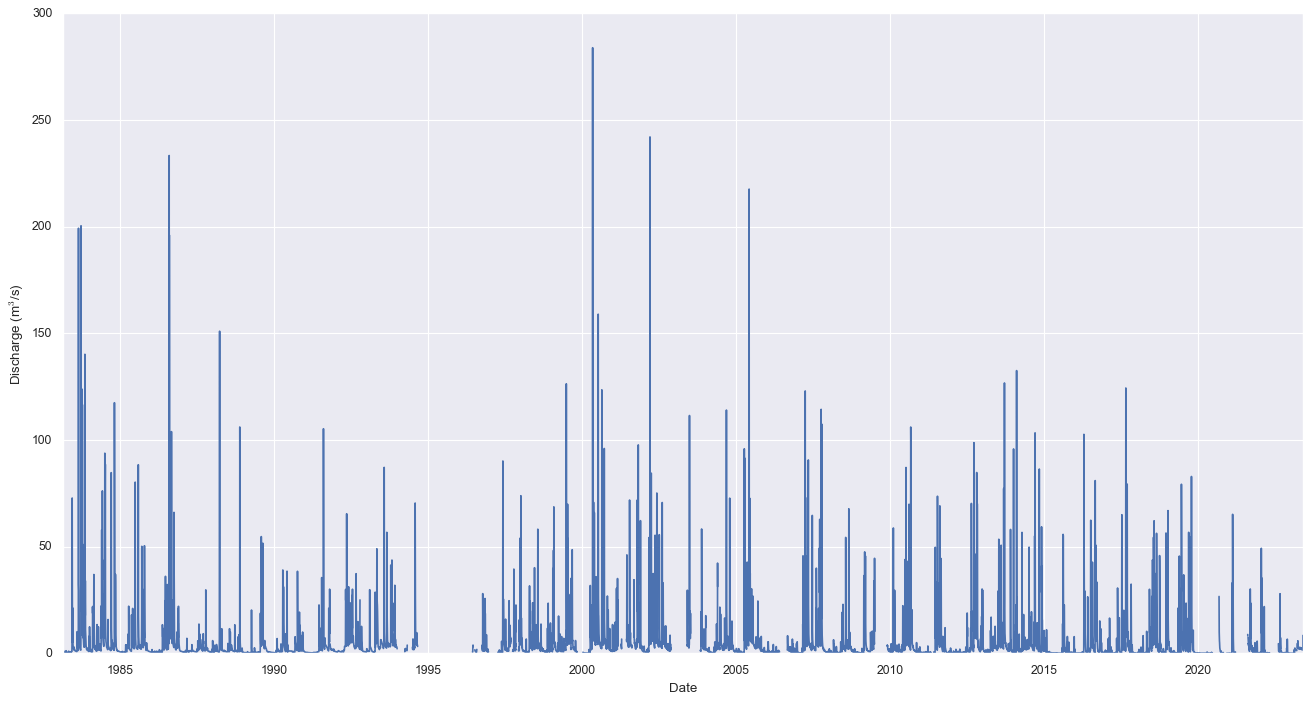

In [640]:
ax1 = DISCHARGE_DAILY['discharge'].plot(figsize=(20, 10));
ax1.set_xlabel('Date');
ax1.set_ylabel('Discharge (m$^3$/s)');

### Calculate monthly mean from daily data

First, we define a percentage of missing value. For this exercise, we use a 50% of missing data in the given month

In [641]:
# Percentage of missing data
max_pct_missing = 50

In [642]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1)
NUMBER_MISSING = NUMBER_MISSING.to_frame()

# change the column name to "missing"
NUMBER_MISSING.columns = ['number_missing'] 

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1) < max_pct_missing
BOOL_MISSING = BOOL_MISSING.to_frame() # Convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

# BOOL_MISSING[~BOOL_MISSING['missing']] # print the dates that does not fulfill the criterion of null data in for each month
# BOOL_MISSING.to_clipboard()

# NUMBER_MISSING.to_clipboard() # Uncomment if you want to visualize all the result in a CSV

In [643]:
DISCHARGE_DAILY.to_clipboard()

Next, we identify the months which contains lower that the max_pct_missing value and the monthly flow is only calculated if 50% o more of recorded value in a given month

In [644]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M',closed="right").apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month < 4, DISCHARGE_MONTHLY.index.year + 1)
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# The water year for this region starts in April (4)
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month < 4, DISCHARGE_DAILY.index.year + 1)
# Change the day in the datetime column
DISCHARGE_MONTHLY.index = DISCHARGE_MONTHLY.index.map(lambda t: t.replace(day=1))
## print the first results
HTML(DISCHARGE_MONTHLY.head(12).to_html(index=True))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

,discharge,year,month,water_year
date,,,,
1983-03-01,0.650267,1983,3,1983
1983-04-01,0.512900,1983,4,1984
1983-05-01,0.602935,1983,5,1984
1983-06-01,9.211733,1983,6,1984
1983-07-01,1.596419,1983,7,1984
1983-08-01,15.885710,1983,8,1984
1983-09-01,17.340833,1983,9,1984
1983-10-01,28.181581,1983,10,1984
1983-11-01,17.450300,1983,11,1984


### Select the period of record to estimate the percentage of average. 

For this section, we will use the period 1991-2020 which is the same as climatology

In [645]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1981) & (DISCHARGE_MONTHLY['year'] <= 2010)]

Calculate the average dischare for each month in the period of record (e.g. 1991-2020)

In [646]:
DISCHARGE_AVERAGE = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).mean()
DISCHARGE_AVERAGE = DISCHARGE_AVERAGE.reindex(columns=['discharge'])

print the monthly average discharge 

In [647]:
HTML(DISCHARGE_AVERAGE.to_html())

,discharge
month,
1,1.722234
2,2.479824
3,3.921823
4,4.537090
5,5.600745
6,8.161277
7,7.498236
8,8.444612
9,7.480657


After this, we calculate the following variables 
1. we calculate the monthly mean discharge as a percentage of average
2. we rank the percentage of average of the current month 
3. we count the notnull values of the current month

In [648]:
# create empty columns in the dataframe
DISCHARGE_MONTHLY['average_percentage'] = np.nan
DISCHARGE_MONTHLY['rank_average'] = np.nan
DISCHARGE_MONTHLY['non_missing'] = np.nan

for i in range(len(DISCHARGE_MONTHLY)):
    # Extract the current month 
    m = DISCHARGE_MONTHLY.month[i]
    # Extract the current year
    y = DISCHARGE_MONTHLY.year[i]
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'rank_average']  = DISCHARGE_MONTHLY.query('month==@m')['discharge'].rank()
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'non_missing']  = DISCHARGE_MONTHLY.query('month==@m')["discharge"].notnull().sum()
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'average_percentage'] = (DISCHARGE_MONTHLY['discharge'][i] - DISCHARGE_AVERAGE.query('month == @m')["discharge"].item()) / DISCHARGE_AVERAGE.query('month == @m')["discharge"].item()
    

### Calculate the percentile using Weibull formula

Calculate the percentile using this formula

$$
\ percentile = \frac{i}{N+1}
$$ 


where _i_ is the rank of the current month and _N_ is the number of months in the period of record 

In [649]:
DISCHARGE_MONTHLY['percentile'] = DISCHARGE_MONTHLY['rank_average']/(DISCHARGE_MONTHLY['non_missing']+1)

print the results

In [650]:
HTML(DISCHARGE_MONTHLY.tail(24).to_html())

,discharge,year,month,water_year,average_percentage,rank_average,non_missing,percentile
date,,,,,,,,
2021-06-01,NaN,2021,6,2022,NaN,NaN,34.0,NaN
2021-07-01,NaN,2021,7,2022,NaN,NaN,33.0,NaN
2021-08-01,4.141650,2021,8,2022,-0.509551,10.0,34.0,0.285714
2021-09-01,6.798033,2021,9,2022,-0.091252,18.0,34.0,0.514286
2021-10-01,0.793452,2021,10,2022,-0.882978,3.0,36.0,0.081081
2021-11-01,0.876600,2021,11,2022,-0.805043,7.0,34.0,0.200000
2021-12-01,0.354065,2021,12,2022,-0.810679,6.0,36.0,0.162162
2022-01-01,7.394710,2022,1,2022,3.293672,32.0,35.0,0.888889
2022-02-01,3.047893,2022,2,2022,0.229076,26.0,35.0,0.722222


### Assign the percentile to a category

| Category | Percentile Range |
| :- | :-: |
| High flow | 0.870000 - 1.000000 |
| Above normal | 0.720000 - 0.869999 |
| Normal range | 0.280000 - 0.719999 |
| Below normal | 0.130000 - 0.279999 |
| Low flow | 0.000000 - 0.129999 |

In [651]:
criteria = [DISCHARGE_MONTHLY['percentile'].between(0.87,1.00),
            DISCHARGE_MONTHLY['percentile'].between(0.72,0.87),
            DISCHARGE_MONTHLY['percentile'].between(0.28,0.72),
            DISCHARGE_MONTHLY['percentile'].between(0.13,0.28),
            DISCHARGE_MONTHLY['percentile'].between(0.00,0.13)]

values = ['High flow','Above normal','Normal range','Below normal','Low flow']

DISCHARGE_MONTHLY['percentile_range'] = np.select(criteria,values,None)

Print the results

In [652]:
HTML(DISCHARGE_MONTHLY.tail(24).to_html())

,discharge,year,month,water_year,average_percentage,rank_average,non_missing,percentile,percentile_range
date,,,,,,,,,
2021-06-01,NaN,2021,6,2022,NaN,NaN,34.0,NaN,None
2021-07-01,NaN,2021,7,2022,NaN,NaN,33.0,NaN,None
2021-08-01,4.141650,2021,8,2022,-0.509551,10.0,34.0,0.285714,Normal range
2021-09-01,6.798033,2021,9,2022,-0.091252,18.0,34.0,0.514286,Normal range
2021-10-01,0.793452,2021,10,2022,-0.882978,3.0,36.0,0.081081,Low flow
2021-11-01,0.876600,2021,11,2022,-0.805043,7.0,34.0,0.200000,Below normal
2021-12-01,0.354065,2021,12,2022,-0.810679,6.0,36.0,0.162162,Below normal
2022-01-01,7.394710,2022,1,2022,3.293672,32.0,35.0,0.888889,High flow
2022-02-01,3.047893,2022,2,2022,0.229076,26.0,35.0,0.722222,Above normal


Make a plot of the Percentile and visualize the percentile category

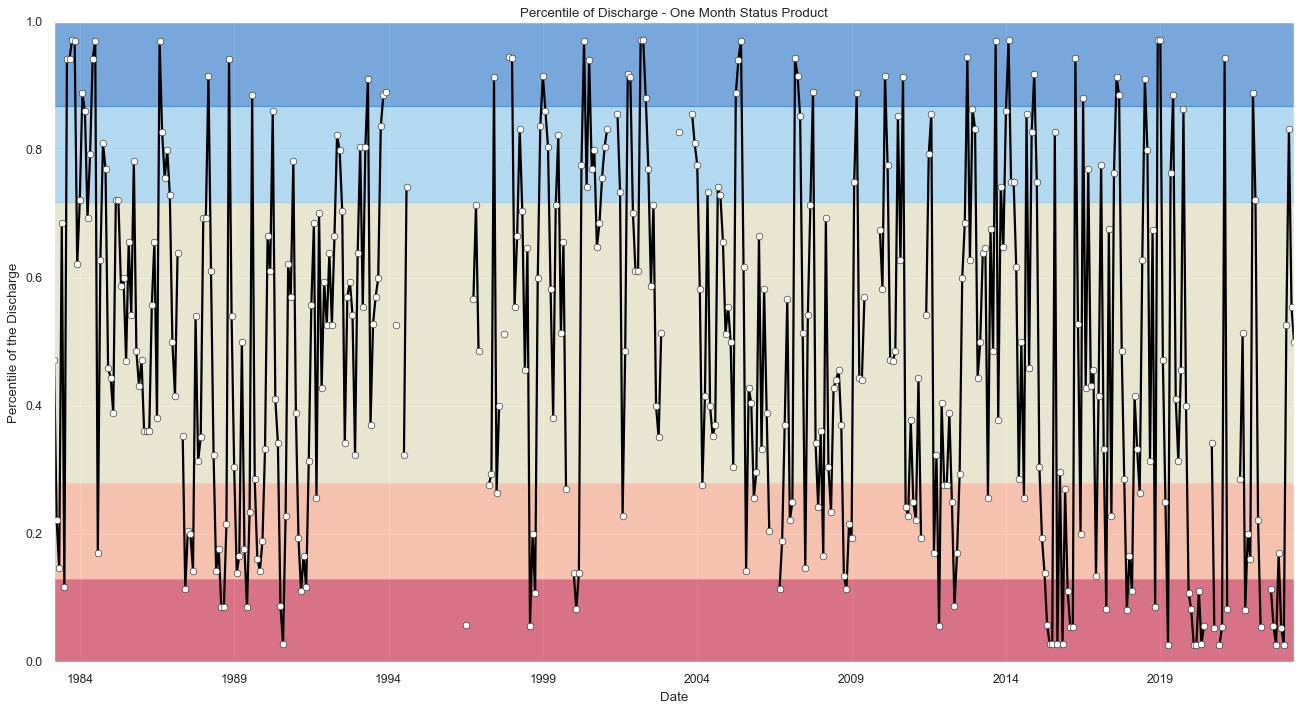

In [653]:
ax = DISCHARGE_MONTHLY['percentile'].plot(figsize=(20, 10),color='black',linestyle='-', linewidth=2, marker='o', mfc='white', mec='k')
ax.axhspan(0.0, 0.13, color='#CD233F',alpha=0.6)
ax.axhspan(0.13, 0.28, color='#FFA885',alpha=0.6)
ax.axhspan(0.28, 0.72, color='#E7E2BC',alpha=0.6)
ax.axhspan(0.72, 0.87, color='#8ECEEE',alpha=0.6)
ax.axhspan(0.87, 1.00, color='#2C7DCD',alpha=0.6)
ax.set_xlim([DISCHARGE_MONTHLY.index[0],DISCHARGE_MONTHLY.index[-1]])
ax.set_ylim([0, 1])
ax.set_xlabel('Date')
ax.set_ylabel('Percentile of the Discharge')
ax.set_title('Percentile of Discharge - One Month Status Product');


## Three months status product

Based on the `DISCHARGE_THREE_MONTHS` variable previously calculated, we define two columns with the start month `startMonth` and end month `endMonth` 

In [654]:
DISCHARGE_THREE_MONTHS['startMonth'] = (DISCHARGE_THREE_MONTHS.index - pd.DateOffset(months=2)).month
DISCHARGE_THREE_MONTHS['endMonth'] = DISCHARGE_THREE_MONTHS.index.month
DISCHARGE_THREE_MONTHS['year'] = DISCHARGE_THREE_MONTHS.index.year
DISCHARGE_THREE_MONTHS.index = DISCHARGE_THREE_MONTHS.index.map(lambda t: t.replace(day=1))

print results

In [655]:
HTML(DISCHARGE_THREE_MONTHS.head(12).to_html())

,discharge,startMonth,endMonth,year
date,,,,
1983-03-01,NaN,1,3,1983
1983-04-01,NaN,2,4,1983
1983-05-01,0.588701,3,5,1983
1983-06-01,3.442523,4,6,1983
1983-07-01,3.803696,5,7,1983
1983-08-01,8.897954,6,8,1983
1983-09-01,11.607654,7,9,1983
1983-10-01,20.469375,8,10,1983
1983-11-01,20.990905,9,11,1983


### Select the period of record to estimate the percentage of average. 

For this section, we use the same period (1991-2020)

In [656]:
DISCHARGE_SELECTION_THREE_MONTH = DISCHARGE_THREE_MONTHS[(DISCHARGE_THREE_MONTHS['year'] >= 1981) & (DISCHARGE_THREE_MONTHS['year'] < 2010)]

Calculate the average discharge for each month in the period of record (e.g. 1991-2020)

In [657]:
DISCHARGE_AVERAGE_THREE_MONTH = DISCHARGE_SELECTION_THREE_MONTH.groupby(DISCHARGE_SELECTION_THREE_MONTH.startMonth).mean()
DISCHARGE_AVERAGE_THREE_MONTH = DISCHARGE_AVERAGE_THREE_MONTH.reindex(columns=['discharge'])

print result

In [658]:
HTML(DISCHARGE_AVERAGE_THREE_MONTH.to_html())

,discharge
startMonth,
1,2.566060
2,3.828478
3,5.132190
4,6.526436
5,7.236927
6,8.021989
7,7.836630
8,7.746609
9,6.331924


After this, we calculate the following variables 
1. we calculate the three months mean discharge as a percentage of average
2. we rank the percentage of average of the current three month period 
3. we count the notnull values of the current three month period

In [659]:
DISCHARGE_THREE_MONTHS['average_percentage'] = np.nan
DISCHARGE_THREE_MONTHS['rank_average'] = np.nan
DISCHARGE_THREE_MONTHS['non_missing'] = np.nan

for i in range(len(DISCHARGE_THREE_MONTHS)):
    # Extract the current month 
    m = DISCHARGE_THREE_MONTHS.startMonth[i]
    # Extract the current year
    y = DISCHARGE_THREE_MONTHS.year[i]
    DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'rank_average']  = DISCHARGE_THREE_MONTHS.query('startMonth==@m')['discharge'].rank()
    DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'non_missing']  = DISCHARGE_THREE_MONTHS.query('startMonth==@m')["discharge"].notnull().sum()
    DISCHARGE_THREE_MONTHS.loc[DISCHARGE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'average_percentage'] = (DISCHARGE_THREE_MONTHS['discharge'][i] - DISCHARGE_AVERAGE_THREE_MONTH.query('startMonth == @m')["discharge"].item()) / DISCHARGE_AVERAGE_THREE_MONTH.query('startMonth == @m')["discharge"].item()
    

print results

In [660]:
HTML(DISCHARGE_THREE_MONTHS.tail(6).to_html())

,discharge,startMonth,endMonth,year,average_percentage,rank_average,non_missing
date,,,,,,,
2022-12-01,0.349076,10,12,2022,-0.924125,1.0,32.0
2023-01-01,0.287829,11,1,2023,-0.882730,1.0,31.0
2023-02-01,0.336925,12,2,2023,-0.823961,4.0,34.0
2023-03-01,1.137536,1,3,2023,-0.556699,18.0,34.0
2023-04-01,1.878902,2,4,2023,-0.509230,16.0,32.0
2023-05-01,2.424449,3,5,2023,-0.527600,15.0,31.0


### Calculate the percentile using Weibull formula

Calculate the percentile using this formula

$$
\ percentile = \frac{i}{N+1}
$$ 


where _i_ is the rank of the current month and _N_ is the number of months in the period of record 

In [661]:
DISCHARGE_THREE_MONTHS['percentile'] = DISCHARGE_THREE_MONTHS['rank_average']/(DISCHARGE_THREE_MONTHS['non_missing']+1)

### Assign the percentile to a category

| Category | Percentile Range |
| :- | :-: |
| High flow | 0.870000 - 1.000000 |
| Above normal | 0.720000 - 0.869999 |
| Normal range | 0.280000 - 0.719999 |
| Below normal | 0.130000 - 0.279999 |
| Low flow | 0.000000 - 0.129999 |

In [662]:
criteria_three_months = [DISCHARGE_THREE_MONTHS['percentile'].between(0.87,1.00),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.72,0.87),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.28,0.72),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.13,0.28),
            DISCHARGE_THREE_MONTHS['percentile'].between(0.00,0.13)]

values_three_months = ['High flow','Above normal','Normal range','Below normal','Low flow']

DISCHARGE_THREE_MONTHS['percentile_range'] = np.select(criteria_three_months,values_three_months,None)

In this section we rename the `startMonth` column into a new column called `period` which describe the three month period of calculation.

In [663]:
row_labels = {1:'JFM',
             2:'FMA',
             3:'MAM',
             4:'AMJ',
             5:'MJJ',
             6:'JJA',
             7:'JAS',
             8:'ASO',
             9:'SON',
             10:'OND',
             11:'NDE',
             12:'DEF'}
DISCHARGE_THREE_MONTHS['period'] = DISCHARGE_THREE_MONTHS['startMonth'].replace(row_labels) 

print results

In [664]:
HTML(DISCHARGE_THREE_MONTHS.tail(6).to_html())

,discharge,startMonth,endMonth,year,average_percentage,rank_average,non_missing,percentile,percentile_range,period
date,,,,,,,,,,
2022-12-01,0.349076,10,12,2022,-0.924125,1.0,32.0,0.030303,Low flow,OND
2023-01-01,0.287829,11,1,2023,-0.882730,1.0,31.0,0.031250,Low flow,NDE
2023-02-01,0.336925,12,2,2023,-0.823961,4.0,34.0,0.114286,Low flow,DEF
2023-03-01,1.137536,1,3,2023,-0.556699,18.0,34.0,0.514286,Normal range,JFM
2023-04-01,1.878902,2,4,2023,-0.509230,16.0,32.0,0.484848,Normal range,FMA
2023-05-01,2.424449,3,5,2023,-0.527600,15.0,31.0,0.468750,Normal range,MAM


Make a plot of the Percentile and visualize the percentile category

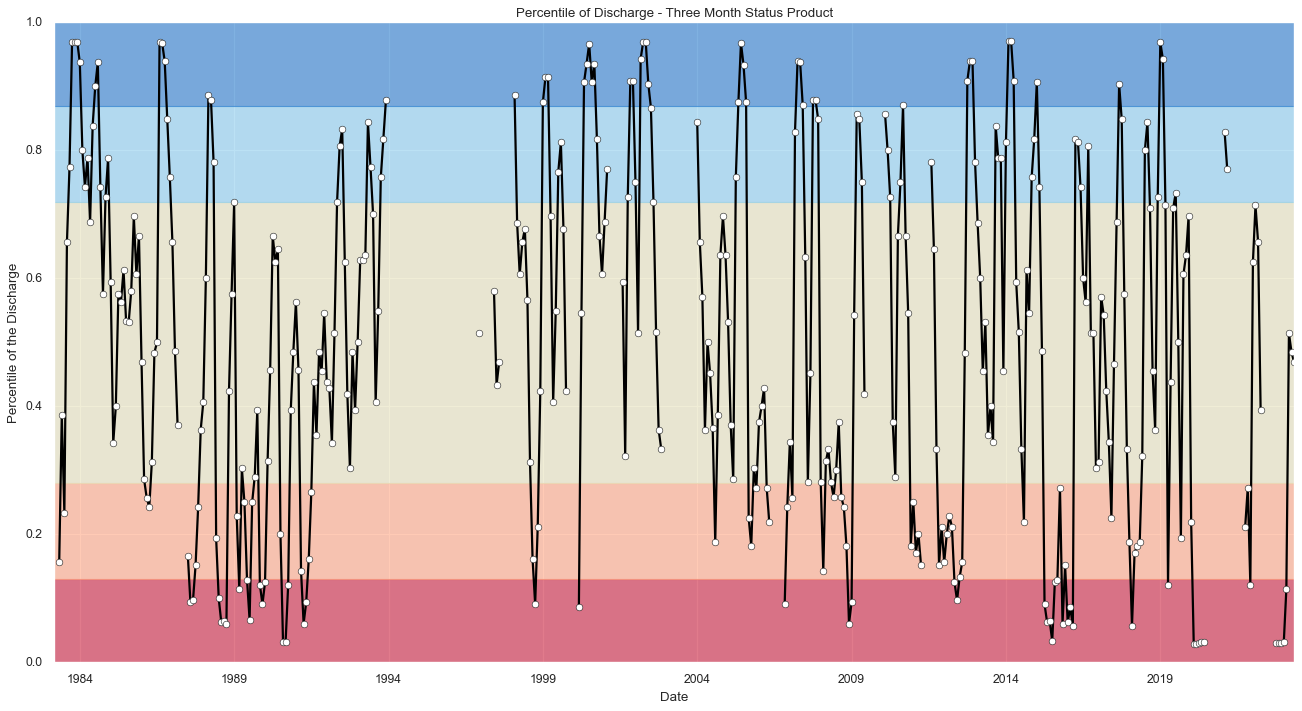

In [665]:
ax2 = DISCHARGE_THREE_MONTHS['percentile'].plot(figsize=(20, 10),color='black',linestyle='-', linewidth=2, marker='o', mfc='white', mec='k')
ax2.axhspan(0.0, 0.13, color='#CD233F',alpha=0.6)
ax2.axhspan(0.13, 0.28, color='#FFA885',alpha=0.6)
ax2.axhspan(0.28, 0.72, color='#E7E2BC',alpha=0.6)
ax2.axhspan(0.72, 0.87, color='#8ECEEE',alpha=0.6)
ax2.axhspan(0.87, 1.00, color='#2C7DCD',alpha=0.6)
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentile of the Discharge')
ax2.set_title('Percentile of Discharge - Three Month Status Product');

## Export to CSV files

In [666]:
# DISCHARGE_MONTHLY[['discharge','month','year','average_percentage','percentile','percentile_range']].to_csv(f'../output/{station_name}_one-month.csv',float_format='%.3f')

In [667]:
# DISCHARGE_THREE_MONTHS[['discharge','startMonth','endMonth','year','average_percentage','percentile','percentile_range']].to_csv(f'../output/{station_name}_three-month.csv',float_format='%.3f')